In [2]:
#default_exp meta.estimators

In [1]:
#hide
from nbdev.showdoc import *

# Meta Estimators

> A set of Meta Estimators suited for density estimation

In [104]:
#export
import sklearn.ensemble as ensemble

from sklearn.preprocessing import QuantileTransformer, PowerTransformer


## NormalizedTarget Estimator -

In [177]:
TRANSFORMERS = {
    'quantile': QuantileTransformer,
    'power': PowerTransformer,
}

def NormalizedTargetEstimator(estimator, transformer = 'quantile', transformer_args = {'output_distribution':'normal'}):
    '''
    a meta estimator (factory) that makes target data normaly distributed through quantile transformer. the transform and inverse transform
    are handled internaly, so the outputs are in the same scale as the original target values
    '''
    
    if transformer.__class__ == str:
        transformer = TRANSFORMERS[transformer](**transformer_args)
    else:
        if isinstance(transformer, type):
            raise ValueError('if not str, transformer must be an instance containing fit, transform and fit_transform methods')
        transformer = transformer
    
    class NormalizedTargetEstimator(estimator):        
        def fit(self, X, y = None):            
            self.transformer = transformer
            super().fit(X, self.transformer.fit_transform(y))
            return self

        def transform(self,X):
            return self.transformer.inverse_transform(super().transform(X))
            
        def predict(self,X):
            return self.transformer.inverse_transform(super().predict(X))
        
        def fit_transform(self,X, y = None):
            self.fit(X, y)            
            return self.transform(X)
        
        def fit_predict(self,X, y = None):
            self.fit(X, y)            
            return self.predict(X)
    
    
    return NormalizedTargetEstimator

You can create an estimator that performs Normlization during fit and inverse transforms the result during inferencce

In [178]:
from sklearn.linear_model import LinearRegression

NormalizedTargetEstimator(LinearRegression)().fit_predict(X_train, y_train)

array([[-280.3831987 , -418.0617244 ],
       [ 519.71498927,  618.28934499],
       [-508.73138768, -558.28899267],
       ...,
       [-602.48233769, -610.03242731],
       [ 555.32162264,  582.28707938],
       [-542.5486155 , -613.02816751]])

## Bagging Estimator - 

In [179]:
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return np.concatenate([estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features)], axis = -1)

class BaggingDensityEstimator(ensemble.BaggingRegressor):
    def sample(self, X, sample_size = None, weights = None):
        
        ensemble._bagging.check_is_fitted(self)
        # Check data
        X = ensemble._bagging.check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = ensemble._bagging._partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = ensemble._bagging.Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            ensemble._bagging.delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))


        return all_y_hat[0]

        
        

The BaggingDensityEstimator is an extension of sklearn BaggingRegressor that allows sampling from each isntance of base estimator

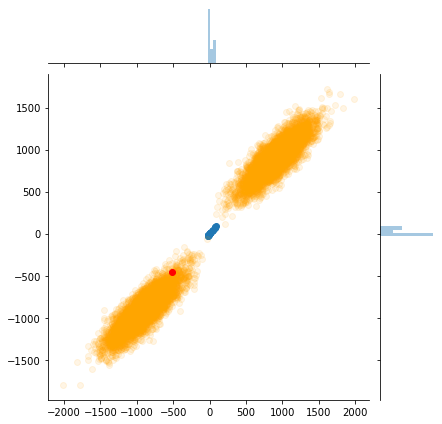

In [180]:
t = BaggingDensityEstimator(LinearRegression(), n_estimators = 10).fit(X,y)
jntplot = sns.jointplot(t.sample(X[0:1]).flatten(), t.sample(X[0:1]).flatten())
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.1)
jntplot.ax_joint.scatter(y[0,0], y[0,1], color = 'red')

We can combine the NormalizedTargetEstimator

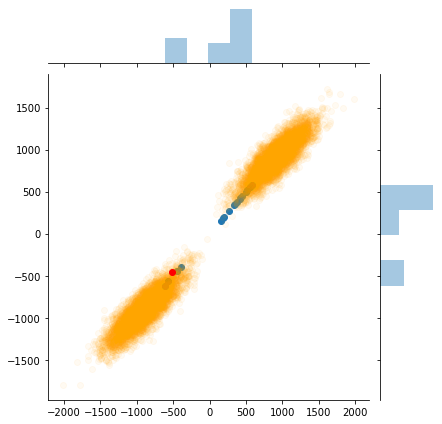

In [182]:
t = BaggingDensityEstimator(NormalizedTargetEstimator(LinearRegression, transformer = 'quantile')(), n_estimators = 10).fit(X,y)
jntplot = sns.jointplot(t.sample(X[0:1]).flatten(), t.sample(X[0:1]).flatten())
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05)
jntplot.ax_joint.scatter(y[0,0], y[0,1], color = 'red')

## ADABoost Estimator -

In [ ]:
class AdaBoostDensityEstiamtor(AdaBoostRegressor):
    def sample(self, X, sample_size = None, weights = None):
        '''Sample according to estimator weights'''

## Stacked Estimator -

> Allows for stacking while making the input of last layer as a sample of last estimators samples

In [ ]:
class StackingDensityEstimator(StackingRegressor):
    def _sample_from_child(self,X):
        '''
        Instead of recieving the prediction of last estimator, it recieves a sumsample of each one of last estimators.
        child estimators contaion a sample method        
        '''
        pass
    
    def  _concatenate_children_output(self, outputs): 
        '''
        Concatenates the children samples 
        '''
        pass
    
    def _set_prior_to_sample():
        '''
        Instead of sampling from data, fit a disstribution  through MLE to data and sample from prior distribution.
        Like in variational auto encoders.
        '''
        pass
    
    def _pass_dist_parameters_instead_of_samples():
        '''
        instead of passing samples to next layer, pass distribution parameters found through MLE
        '''
    NO NEED FOR SAMPLE METHOD SINCE IT WILL IMPLEMENT THE LAST LAYYER METHODS

## Voting Estimator - 

> creates an ensemble of diverse estimators (this is what makes it different from bagging) and estimates the density distribution based on all the estimators outputs